In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [4]:

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.24MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 154kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.45MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.31MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Batch size (number of images): 64
Correct Labels: tensor([6, 6, 4, 1, 4, 0, 9, 4, 4, 2, 3, 7, 1, 3, 7, 7, 4, 4, 3, 8, 1, 2, 2, 0,
        2, 6, 1, 7, 2, 6, 8, 8, 3, 3, 0, 3, 7, 5, 8, 0, 7, 9, 7, 6, 3, 1, 2, 5,
        2, 7, 7, 4, 4, 3, 0, 8, 0, 6, 1, 4, 5, 1, 1, 2])
Shape of images tensor: torch.Size([64, 1, 28, 28])
Squeezing the images tensor: (64, 28, 28)
Un-squeezing the images tensor (axis=3): (64, 1, 28, 1, 28)


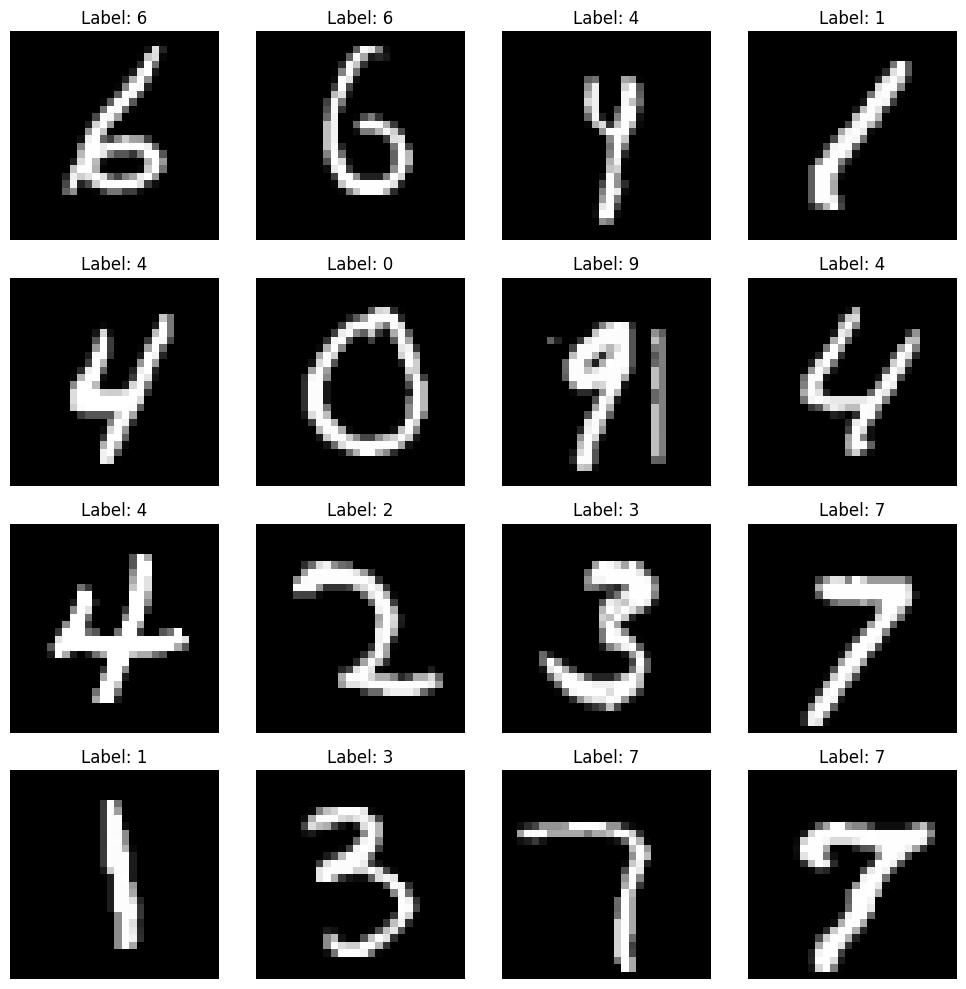

In [6]:
import matplotlib.pyplot as plt
import numpy as np

data_iter = iter(train_loader)
images, labels = next(data_iter)

print(f'Batch size (number of images): {len(images)}')
print(f'Correct Labels: {labels}')
print(f'Shape of images tensor: {images.shape}')

images_np = images.numpy()

print(f'Squeezing the images tensor: {np.squeeze(images_np).shape}')
print(f'Un-squeezing the images tensor (axis=3): {np.expand_dims(images_np, axis=3).shape}')

def visualize_batch(images, labels, batch_size=16):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.flatten()

    for i in range(min(batch_size, len(images))):
        img = np.squeeze(images[i])
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Label: {labels[i].item()}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

visualize_batch(images_np, labels)


In [7]:
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

model = NeuralNetwork().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [9]:
!pip install torchsummary torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=51f3029ca28ca6d930f9ee820948247a9f1117c38c7d06a60456684eea2c4330
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [10]:
from torchsummary import summary
from torchviz import make_dot

print("Model Summary:")
summary(model, input_size=(1, 28, 28))

dummy_input = torch.randn(1, 1, 28, 28, device=device)

graph = make_dot(model(dummy_input), params=dict(model.named_parameters()))
graph.render("mnist_model_architecture", format="png")
print("mnist_model_architecture.png")


Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
            Linear-4                   [-1, 64]           8,256
              ReLU-5                   [-1, 64]               0
            Linear-6                   [-1, 10]             650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.42
Estimated Total Size (MB): 0.43
----------------------------------------------------------------
mnist_model_architecture.png


In [11]:
# Training the model
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/5, Loss: 0.4105
Epoch 2/5, Loss: 0.1888
Epoch 3/5, Loss: 0.1368
Epoch 4/5, Loss: 0.1100
Epoch 5/5, Loss: 0.0934


In [12]:
model_path = "mnist_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

loaded_model = NeuralNetwork().to(device)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()
print("Model loaded and ready for inference.")

correct = 0
total = 0
class_correct = [0] * 10
class_total = [0] * 10

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = loaded_model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += (predicted[i] == label).item()
            class_total[label] += 1

accuracy = 100 * correct / total
print(f"Overall Test Accuracy: {accuracy:.2f}%")

for i in range(10):
    if class_total[i] > 0:
        print(f"Accuracy for class {i}: {100 * class_correct[i] / class_total[i]:.2f}%")
    else:
        print(f"Accuracy for class {i}: N/A (no samples)")


Model saved to mnist_model.pth
Model loaded and ready for inference.


<ipython-input-12-b335a05bb617>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_path))


Overall Test Accuracy: 96.79%
Accuracy for class 0: 97.04%
Accuracy for class 1: 98.68%
Accuracy for class 2: 96.12%
Accuracy for class 3: 96.83%
Accuracy for class 4: 98.07%
Accuracy for class 5: 96.97%
Accuracy for class 6: 97.29%
Accuracy for class 7: 94.26%
Accuracy for class 8: 97.13%
Accuracy for class 9: 95.44%


In [13]:
def infer(image):
    model.eval()
    image = image.to(device).unsqueeze(0)
    with torch.no_grad():
        output = model(image)
        _, predicted_label = torch.max(output, 1)
    return predicted_label.item()

sample_image, sample_label = test_dataset[0]
predicted_class = infer(sample_image)
print(f"Actual Label: {sample_label}, Predicted Label: {predicted_class}")


Actual Label: 7, Predicted Label: 7
